# PyTorch Workglow

Let's explore a an example PyTorch end-to-end workflow.
Resources:

In [1]:
what_were_covering = {1: "data (prepare and load)",
                       2: "build model",
                       3: "fitting the model to data (training)",
                       4: "making predictions and evaluating a model (inference)",
                       5: "saving and loading a model",
                       6: "putting all together"}

what_were_covering


{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluting a model (inference)',
 5: 'saving and loading a model',
 6: 'putting all together'}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for graphs
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu118'

## 1. Data (preparing and loading)

Data can ben almost anything... in machine learning:
* excel speadsheet
* images of any kind
* Videos (YouTube, has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representation.

To showcase this , let's create some *known* data using the linear regression formula

We'll use a linear regression formula to make a straight line with *known* **parameters**

In [3]:
# create *known* parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### splitting data into training and test sets (one of the most important concepts in machine learning in general)



In [5]:
# create a train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[: train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
    Plot training data, test data and compares predictions.
  """

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # show the legend
  plt.legend(prop={"size": 14})


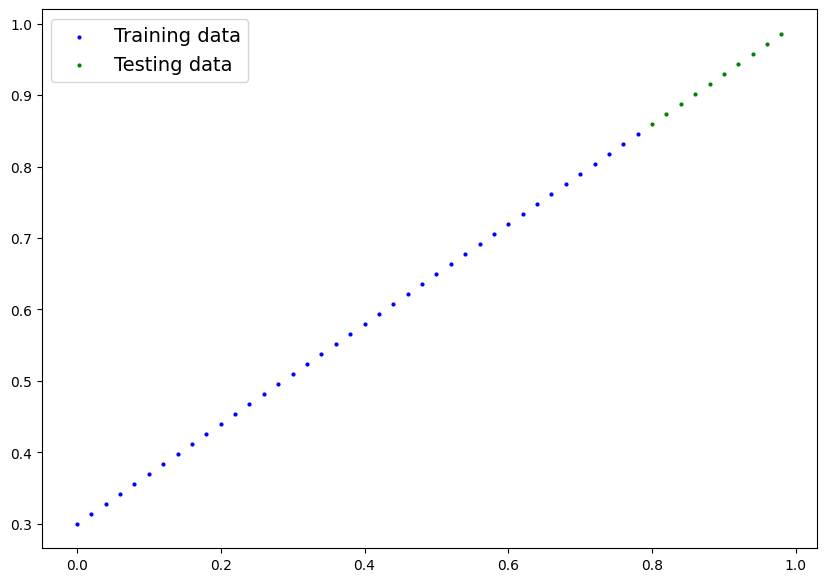

In [7]:
plot_predictions()

## 2. Build model
Our first PyTorch model!

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the wieght & bias values we used to create the data)

How does it do so?


Through two main algorithms:
1. Gradient descent
2. Backpropagation


In [8]:
# create linear regression mdel class
from torch import nn

class LinearRegressionModel(nn.Module): # <- base class for all neural network modules
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random value and try to adjust it to the ideal values
                                            requires_grad=True, # <- can this parameter be undated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32

    self.bias = nn.Parameter(torch.randn(1, # <- start with a random value and try to adjust it to the ideal values
                                            requires_grad=True, # <- can this parameter be undated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula



### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs ( a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they  will help with gradient descent
* def forword() - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### checking the contents of our PyTorch model

In [15]:
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.2345], requires_grad=True),
 Parameter containing:
 tensor([0.2303], requires_grad=True)]

### Makin predicition using `torch.inference_mode()`

To check or model's predictive power, let's see how well it predicts `y_test` based on `X_test`
When we pass data through our model, it's going to run it through the `forward()` method.

In [21]:
# make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

#  you can do something similar with torch.no_grad()
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.4179],
        [0.4226],
        [0.4273],
        [0.4320],
        [0.4367],
        [0.4413],
        [0.4460],
        [0.4507],
        [0.4554],
        [0.4601]])

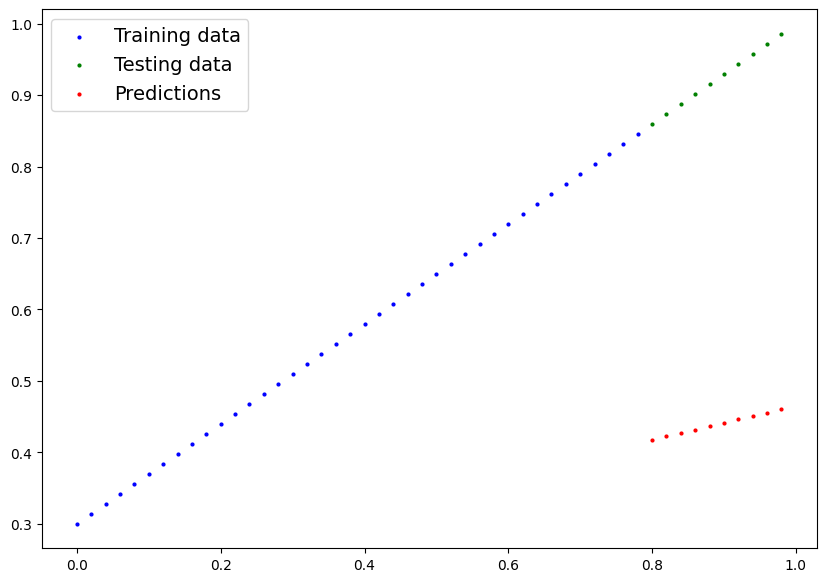

In [20]:
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some _unknown_ parameters (these may be random) to some _known_ parameters.
Or in other words from a poor representation of the data to a better representation of the data.

One way to meeasure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss fuction may also be called cost function or criterion in different areas.
* **Loss function:** A `function` to measure how wrong your model's predctions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias)

A specifically for PyTorch, we need:

* A training loop
* A testing loop

In [22]:
# check out or model's parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.2345])), ('bias', tensor([0.2303]))])

In [24]:
## setup a loss function
loss_fn = nn.L1Loss()

## setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimize step

In [56]:
# An epoch is one loop through the data... (this is a hyperparameter because we've set it ourselves)
epochs = 100

# 0. Loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients
  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  # 6. Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): # turn off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch:{epoch} | Loss: {loss} |Test loss: {test_loss}")
    print(model_0.state_dict())

Loss: 0.007190808653831482
Epoch:0 | Loss: 0.007190808653831482 |Test loss: 0.009028583765029907
OrderedDict([('weights', tensor([0.6906])), ('bias', tensor([0.2993]))])
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Epoch:10 | Loss: 0.007190808653831482 |Test loss: 0.009028583765029907
OrderedDict([('weights', tensor([0.6906])), ('bias', tensor([0.2993]))])
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Loss: 0.004330190364271402
Loss: 0.007190808653831482
Epoch:20 | Loss: 0.007190808653831482 |Test loss: 0.009028583765029907
OrderedDict([('weights', tensor([0.6906])), ('bias', tensor([0.2993]))])
Lo

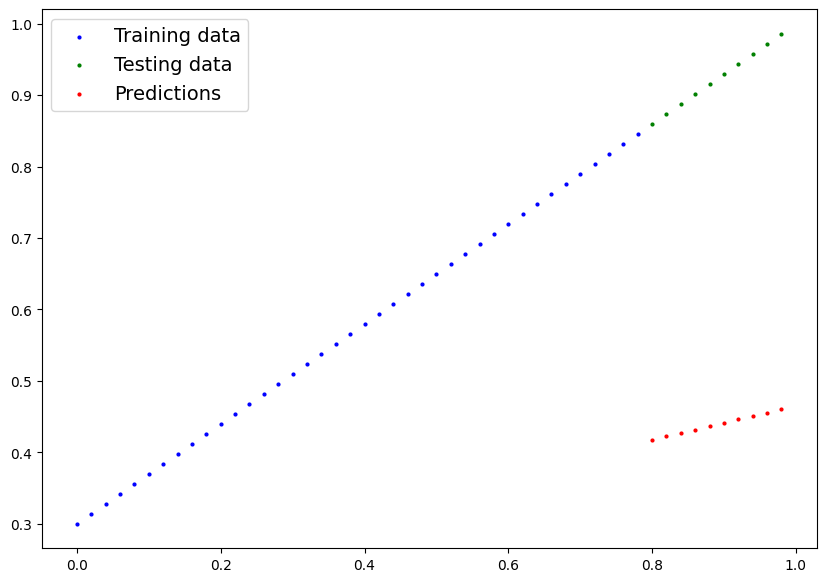

In [57]:
plot_predictions(predictions=y_preds)

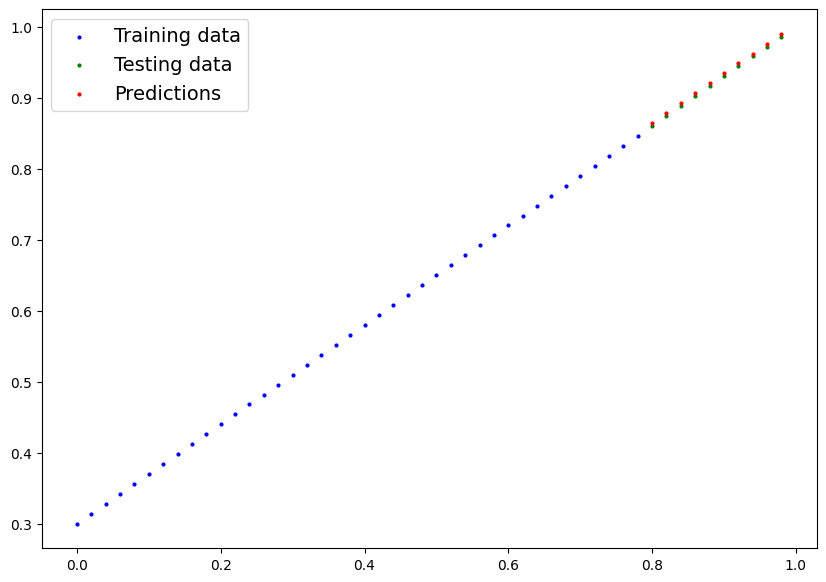

In [58]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)